In [1]:
import itertools
from functools import lru_cache
import pandas as pd
import numpy as np
import os
import os.path as op
import networkx as nx
from nilearn.image import load_img, mean_img, math_img
from nilearn import plotting
from nilearn.masking import apply_mask
import subprocess
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams.update({'font.size': 12})
%matplotlib inline

In [2]:
project_dir = '/Users/ari/GraphLearn'
# project_dir = '/Volumes/GraphLearning'
fmriprep_dir = op.join(project_dir, 'derived/fmriprep')
pymvpa_dir = op.join(project_dir, 'derived/pymvpa_searchlight-2020-08-05')
lower_bound_dir = op.join(project_dir, 'derived/rsa_lower_bound_pymvpa-2020-08-05')
lower_bound_null_model_dir = op.join(project_dir, 'derived/rsa_lower_bound_pymvpa_random_null-2021-01-02')

In [3]:
@lru_cache()
def load_rho_map(subject, graph, metric):
    rho = load_img(f'{output_dir}/sub-{subject}/results/sub-{subject}_searchlight-lsa_metric-{metric}_radius-3_desc-{graph.lower()}-map-rho.nii.gz')
    return rho


@lru_cache()
def load_bold_mask(subject):
    """
    Load bold mask intersection across all runs

    derived/fmriprep/sub-{subject}/ses-2/func/sub-{subject}_ses-2_task-graphlocalizer_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
    """
    runmasks = []
    for run in range(1, 9):
        runmask = load_img('{}/sub-{}/ses-2/func/sub-{}_ses-2_task-graphrepresentation_run-{}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(
            fmriprep_dir, subject, subject, run))
        runmasks.append(runmask)
    boldmask = math_img("img0 * img1 * img2 * img3 * img4 * img5 * img6 * img7",
                        img0=runmasks[0],
                        img1=runmasks[1],
                        img2=runmasks[2],
                        img3=runmasks[3],
                        img4=runmasks[4],
                        img5=runmasks[5],
                        img6=runmasks[6],
                        img7=runmasks[7])
    return boldmask

In [4]:
from roi_loader import Loader
loader = Loader(project_dir)

from graphs import (
    modular,
    ring_lattice,
    graph_df,
    subjects,
    subjects_lattice,
    subjects_modular
)

subjects = dict(all=subjects, Modular=subjects_modular, Lattice=subjects_lattice)
print('All Subjects:')
print(subjects['all'])

print('Modular:')
print(subjects['Modular'])

print('Lattice:')
print(subjects['Lattice'])

All Subjects:
['GLS003', 'GLS004', 'GLS005', 'GLS006', 'GLS008', 'GLS009', 'GLS010', 'GLS011', 'GLS013', 'GLS014', 'GLS017', 'GLS018', 'GLS019', 'GLS020', 'GLS021', 'GLS022', 'GLS023', 'GLS024', 'GLS025', 'GLS026', 'GLS027', 'GLS028', 'GLS030', 'GLS033', 'GLS037', 'GLS038', 'GLS039', 'GLS040', 'GLS043', 'GLS044', 'GLS045']
Modular:
['GLS003', 'GLS004', 'GLS008', 'GLS010', 'GLS011', 'GLS013', 'GLS018', 'GLS019', 'GLS022', 'GLS023', 'GLS025', 'GLS026', 'GLS037', 'GLS038', 'GLS039', 'GLS044']
Lattice:
['GLS005', 'GLS006', 'GLS009', 'GLS014', 'GLS017', 'GLS020', 'GLS021', 'GLS024', 'GLS027', 'GLS028', 'GLS030', 'GLS033', 'GLS040', 'GLS043', 'GLS045']


In [5]:
graphs = ('Lattice', 'Modular')

In [6]:
mean_consistency_maps = dict()
pairwise_metric = 'euclidean'
# pairwise_metric = 'correlation'
consistency_metric = 'pearson'
# consistency_metric = 'spearman'
for subject in subjects['all']:
    img = load_img(f'{pymvpa_dir}/sub-{subject}/results/sub-{subject}_searchlight-lss_pairwise-metric-{pairwise_metric}_consistency-metric-{consistency_metric}_radius-3_desc-consistency-map.nii.gz')
    mean_consistency_maps[subject] = mean_img(img)

Mean for all subjects


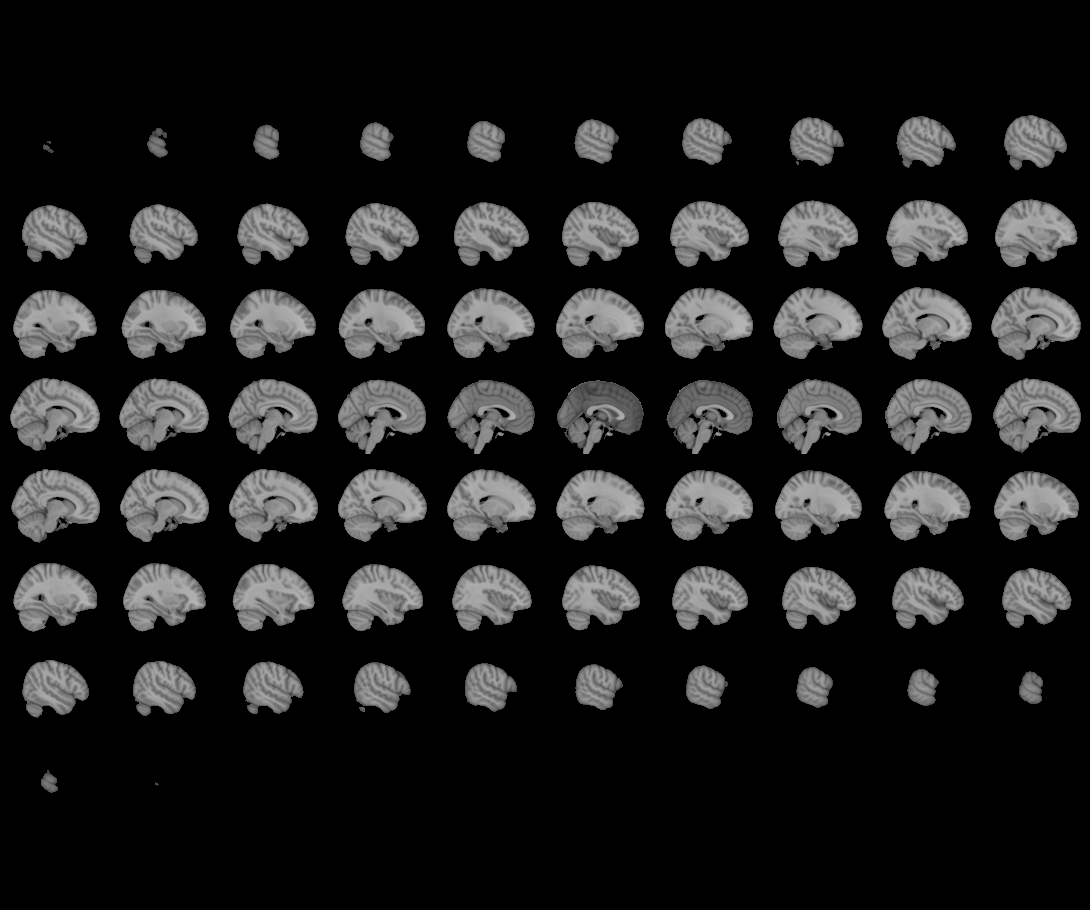
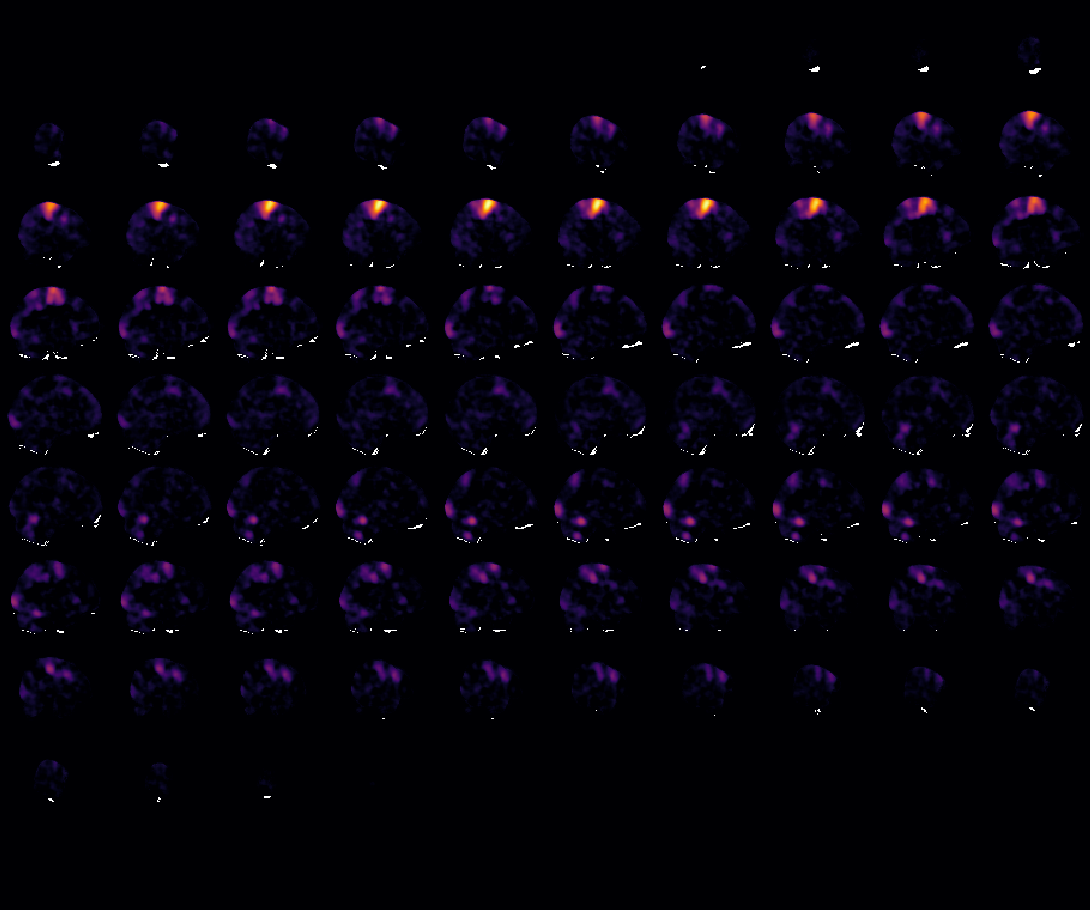

In [7]:
mean_consistency = mean_img(mean_consistency_maps[s] for s in subjects['all'])
plotting.view_img(math_img('img * (img >= 0) + 0.0001', img=mean_consistency),
#                   threshold=0.01,
                  symmetric_cmap=False,
                  cmap='inferno',
                  resampling_interpolation='nearest',
                  )

Modular minus Lattice


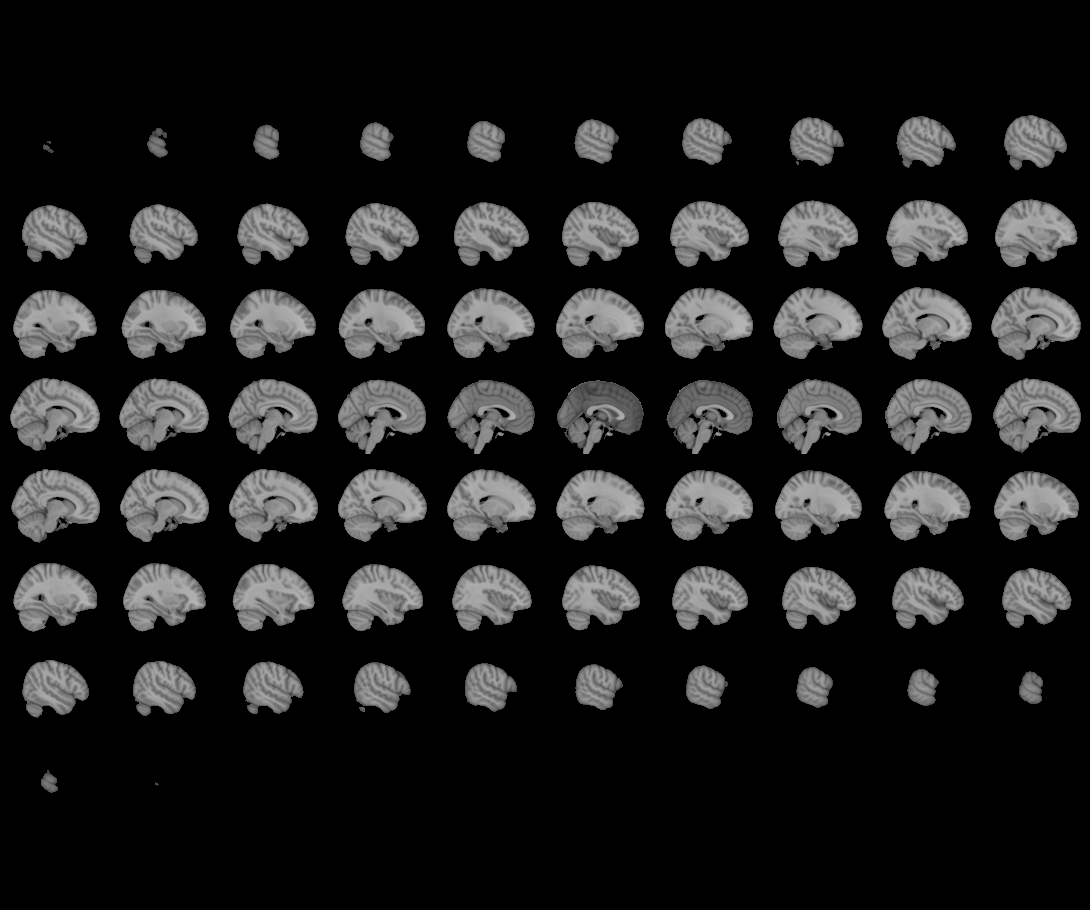
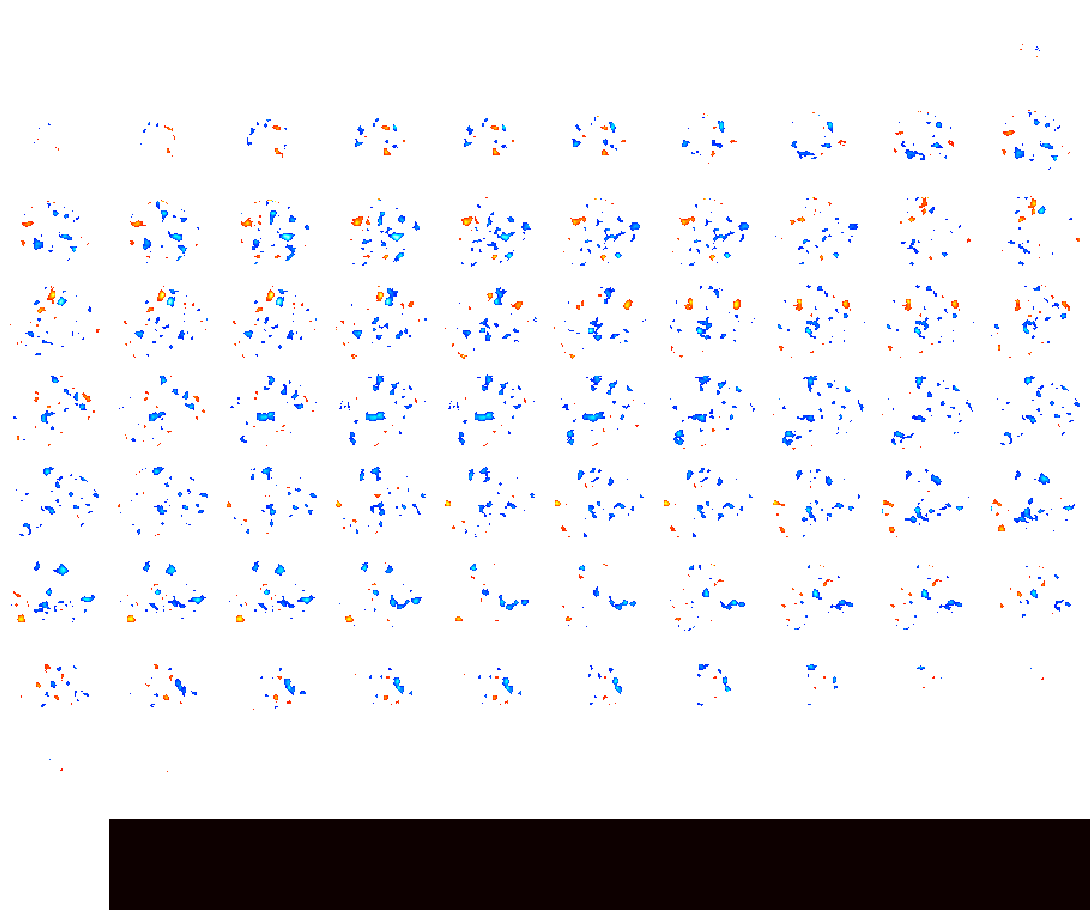

In [8]:
modular_avg = mean_img(mean_consistency_maps[s] for s in subjects['Modular'])
lattice_avg = mean_img(mean_consistency_maps[s] for s in subjects['Lattice'])
diff_img = math_img('img1 - img2', img1=modular_avg, img2=lattice_avg)
plotting.view_img(diff_img,
                  threshold=0.02,
                  resampling_interpolation='nearest')


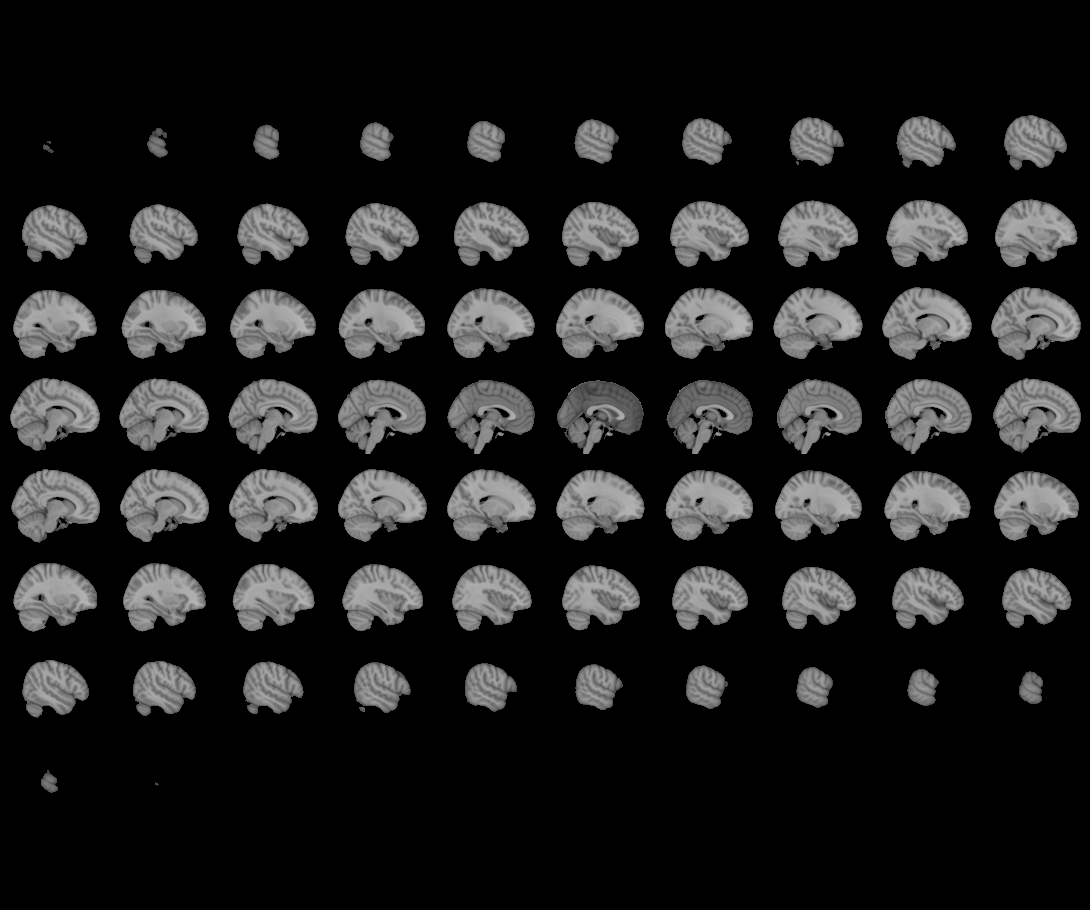
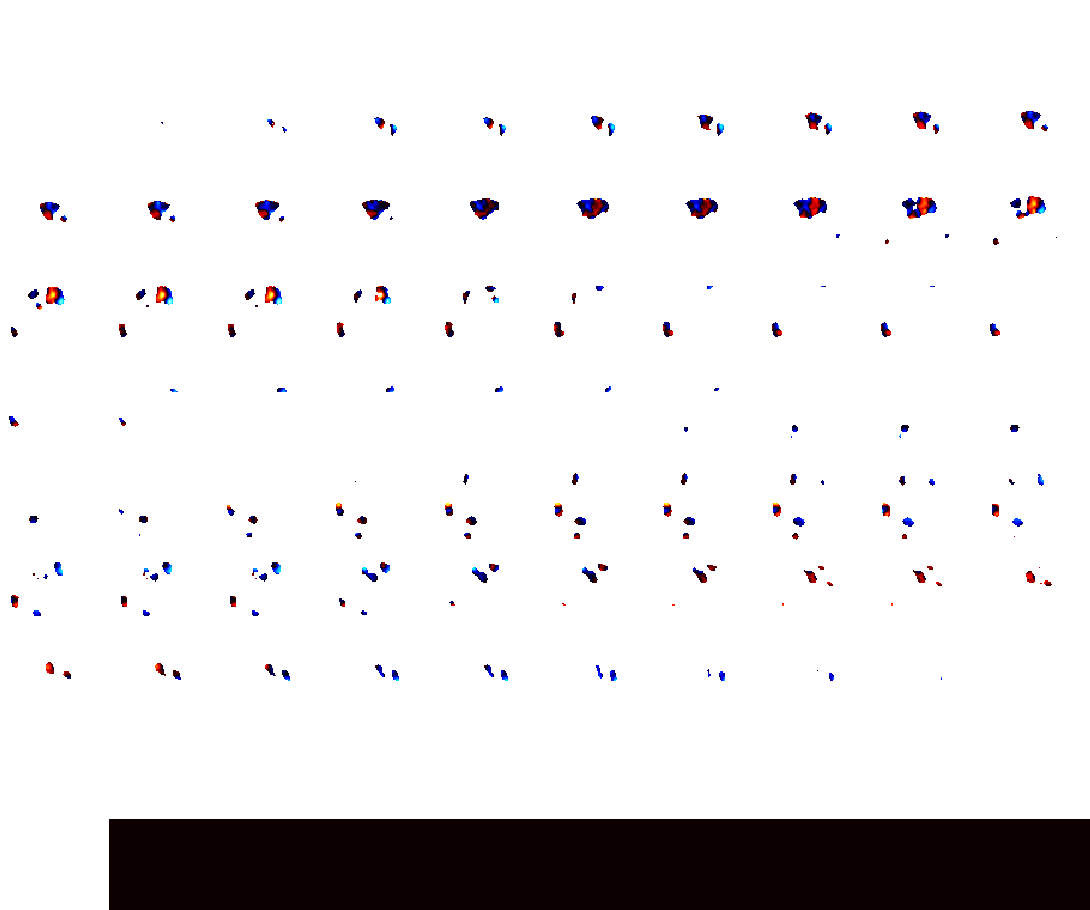

In [9]:
thresholded_diff_img = math_img('(img1 > 0.03) * (img2)', img1=mean_consistency, img2=diff_img)
plotting.view_img(thresholded_diff_img,
#                   threshold=0.02,
                  resampling_interpolation='nearest')

# Lower bounds

## Null Model

In [9]:
lower_null_volmaxes_all = load_img(f'{lower_bound_null_model_dir}/rdm_lower-bound_pairwise-metric-{pairwise_metric}_radius-3_comparison-metric-{comparison_metric}_ordering-random_volmaxes_all.nii.gz')
# lower_null_volmaxes_modular = load_img(f'{lower_bound_null_model_dir}/rdm_lower-bound_pairwise-metric-{pairwise_metric}_radius-3_comparison-metric-{comparison_metric}_ordering-random_volmaxes_modular.nii.gz')
# lower_null_volmaxes_lattice = load_img(f'{lower_bound_null_model_dir}/rdm_lower-bound_pairwise-metric-{pairwise_metric}_radius-3_comparison-metric-{comparison_metric}_ordering-random_volmaxes_lattice.nii.gz')

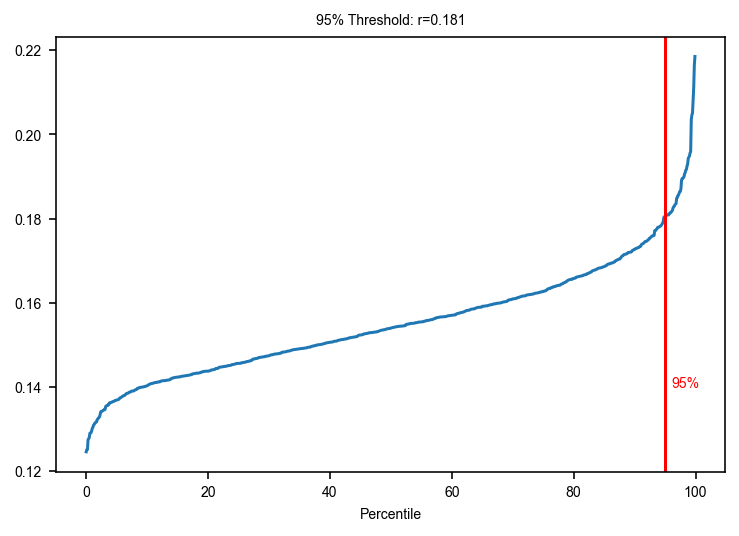

In [28]:
sorted_null_corrs = np.sort(lower_null_volmaxes_all.get_fdata().squeeze())
null_threshold = sorted_null_corrs[950]

f, ax = plt.subplots()
ax.plot(sorted_null_corrs)
ax.axvline(950, color='r')
ax.set_xlabel('Percentile')
ax.set_xticks([0, 200, 400, 600, 800, 1000])
ax.set_xticklabels(['0', '20', '40', '60', '80', '100'])
ax.text(x=960, y= 0.14, s="95%", color='r')
ax.set_title(f'95% Threshold: r={null_threshold:0.3f}');

In [18]:
def load_lower_bound(pairwise_metric, comparison_metric, ordering, graph):
    img = load_img(f'{lower_bound_dir}/rdm_lower-bound_pairwise-metric-{pairwise_metric}_radius-3_comparison-metric-{comparison_metric}_ordering-{ordering}_{graph}.nii.gz')
    return img

## Movement

In [19]:
ordering = 'movement'
comparison_metric = 'pearson'
pairwise_metric = 'euclidean'
lower_movement_modular = load_lower_bound(pairwise_metric, comparison_metric, ordering, 'modular')
lower_movement_lattice = load_lower_bound(pairwise_metric, comparison_metric, ordering, 'lattice')
lower_movement_all = load_lower_bound(pairwise_metric, comparison_metric, ordering, 'all')

## Fig 3d

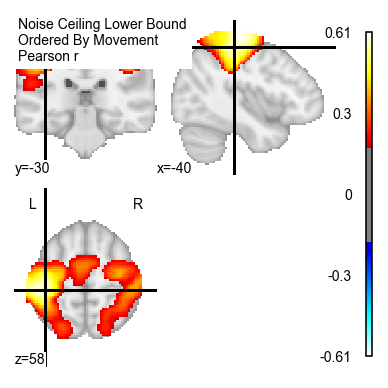

In [20]:
mpl.rcParams.update({'font.family': ['sans-serif'],
                             'font.sans-serif': ['Arial'],
                             "font.size": 7,
                             "axes.titlesize": 7,
                             "axes.labelsize": 7,
                             "xtick.labelsize": 7,
                             "ytick.labelsize": 7,
                             'legend.fontsize': 7,
                             'savefig.dpi': 600,
                             'legend.title_fontsize': 7})
f = plt.figure(figsize=(2.5, 2.5))
display = plotting.plot_stat_map(lower_movement_all,
                                 cut_coords=(-40, -30, 58),
                                 threshold=null_threshold,
                                 annotate=False,
                                 display_mode='tiled',
                                 figure=f)
display.annotate(size=7, font='Arial')
display.title('Noise Ceiling Lower Bound\nOrdered By Movement\nPearson r', size=7, font='Arial', bgcolor='white', color='black')
f.savefig('images/noise_ceiling_motor.pdf')

## Supplementary figure (cerebellum)

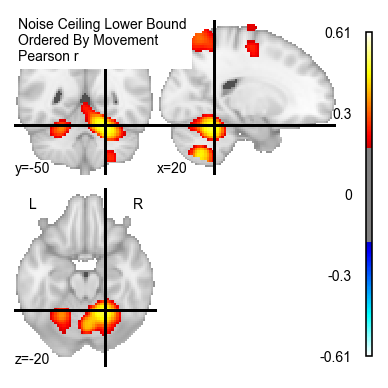

In [21]:
mpl.rcParams.update({'font.family': ['sans-serif'],
                             'font.sans-serif': ['Arial'],
                             "font.size": 7,
                             "axes.titlesize": 7,
                             "axes.labelsize": 7,
                             "xtick.labelsize": 7,
                             "ytick.labelsize": 7,
                             'legend.fontsize': 7,
                             'savefig.dpi': 600,
                             'legend.title_fontsize': 7})
f = plt.figure(figsize=(2.5, 2.5))
display = plotting.plot_stat_map(lower_movement_all,
                                 cut_coords=(20, -50, -20),
                                 threshold=null_threshold,
                                 annotate=False,
                                 display_mode='tiled',
                                 figure=f)
display.annotate(size=7, font='Arial')
display.title('Noise Ceiling Lower Bound\nOrdered By Movement\nPearson r', size=7, font='Arial', bgcolor='white', color='black')
f.savefig('images/noise_ceiling_motor_cerebellum.pdf')

In [22]:
import gc
gc.collect()

11791

## Shape

In [23]:
ordering = 'shape'
comparison_metric = 'pearson'
pairwise_metric = 'euclidean'
lower_shape_modular = load_lower_bound(pairwise_metric, comparison_metric, ordering, 'modular')
lower_shape_lattice = load_lower_bound(pairwise_metric, comparison_metric, ordering, 'lattice')
lower_shape_all = load_lower_bound(pairwise_metric, comparison_metric, ordering, 'all')

## Figure 4d

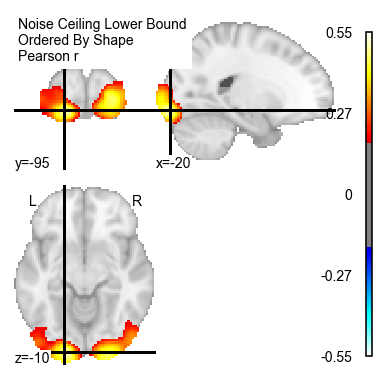

In [24]:
mpl.rcParams.update({'font.family': ['sans-serif'],
                             'font.sans-serif': ['Arial'],
                             "font.size": 7,
                             "axes.titlesize": 7,
                             "axes.labelsize": 7,
                             "xtick.labelsize": 7,
                             "ytick.labelsize": 7,
                             'legend.fontsize': 7,
                             'savefig.dpi': 600,
                             'legend.title_fontsize': 7})
f = plt.figure(figsize=(2.5, 2.5))
display = plotting.plot_stat_map(lower_shape_all,
                                 cut_coords=(-20, -95, -10),
                                 threshold=null_threshold,
                                 annotate=False,
                                 display_mode='tiled',
                                 figure=f)
display.annotate(size=7, font='Arial')
display.title('Noise Ceiling Lower Bound\nOrdered By Shape\nPearson r', size=7, font='Arial', bgcolor='white', color='black')
f.savefig('images/noise_ceiling_shape.pdf')

## Node


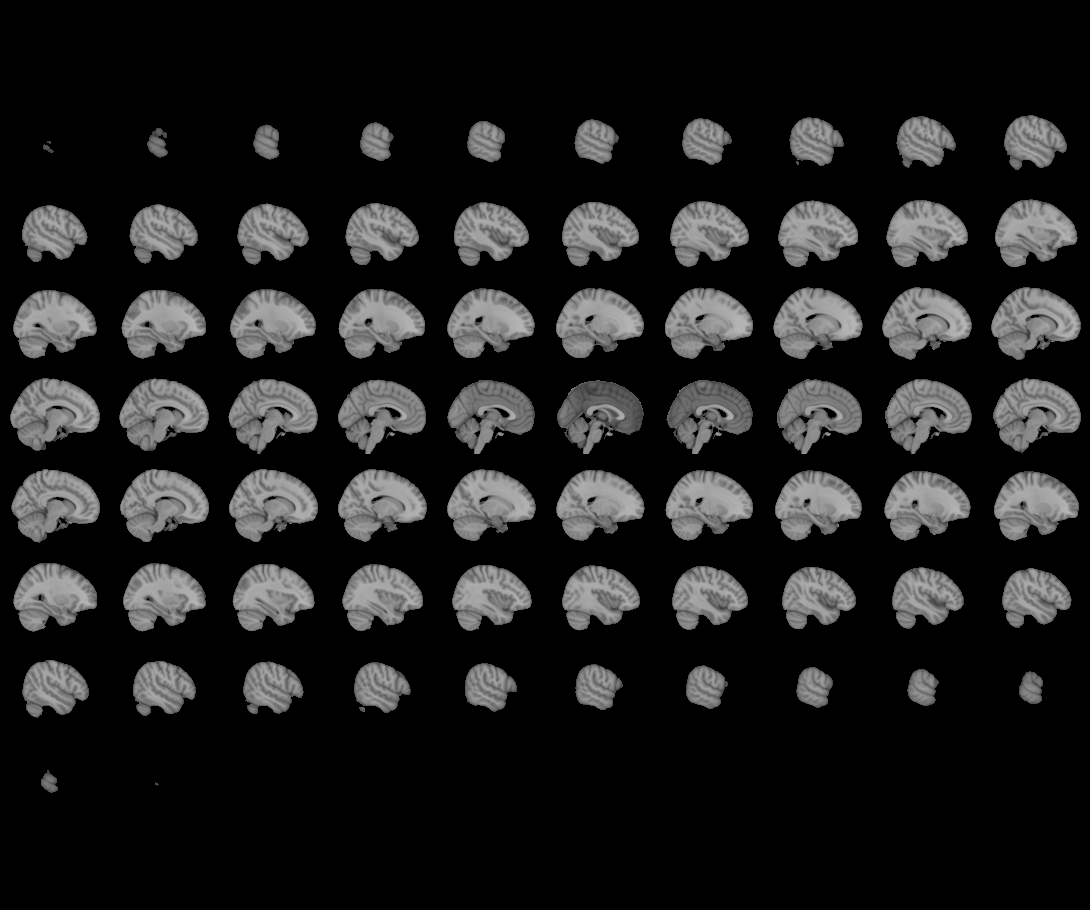
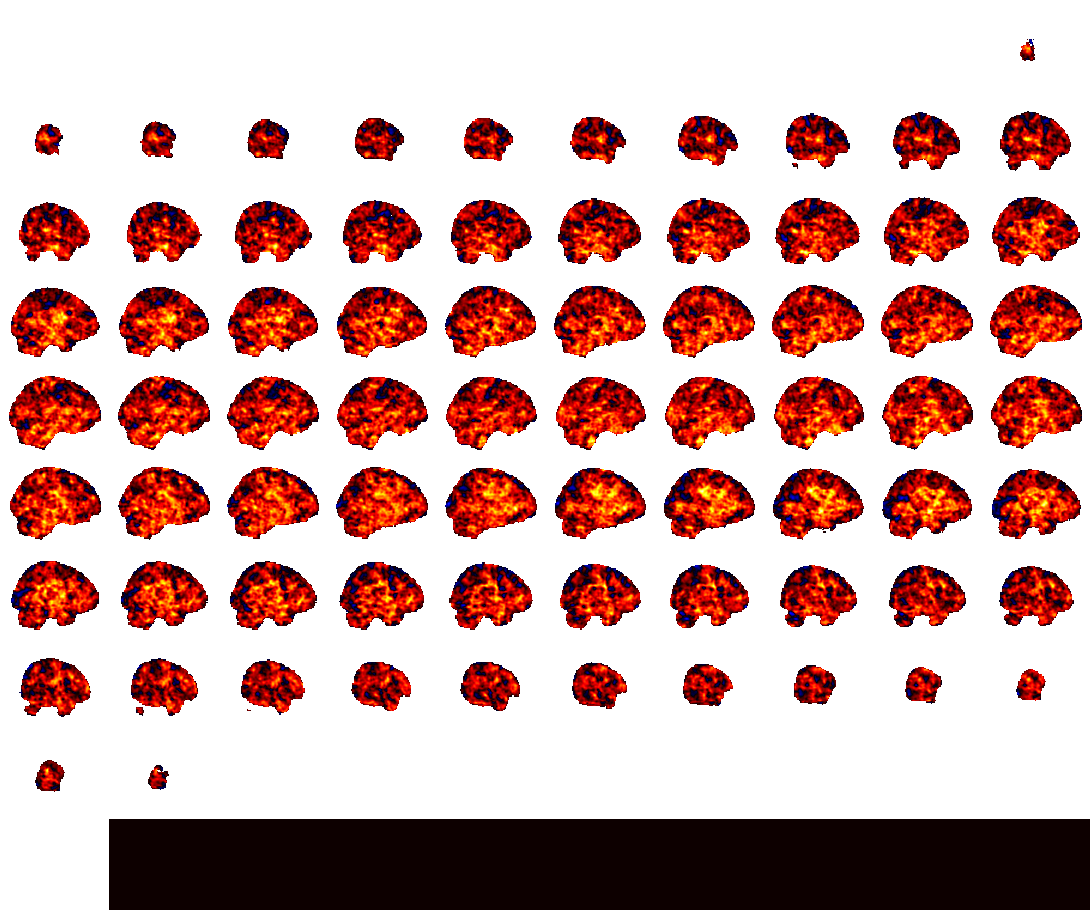

In [26]:
comparison_metric = 'pearson'
pairwise_metric = 'correlation'
lower_node_modular = load_lower_bound(pairwise_metric, comparison_metric, 'node', 'modular')
lower_node_lattice = load_lower_bound(pairwise_metric, comparison_metric, 'node', 'lattice')
lower_node_all = load_lower_bound(pairwise_metric, comparison_metric, 'node', 'all')
plotting.view_img(mean_img([lower_node_lattice, lower_node_modular]))

## Figure 5a

In [ ]:
mpl.rcParams.update({'font.family': ['sans-serif'],
                             'font.sans-serif': ['Arial'],
                             "font.size": 7,
                             "axes.titlesize": 7,
                             "axes.labelsize": 7,
                             "xtick.labelsize": 7,
                             "ytick.labelsize": 7,
                             'legend.fontsize': 7,
                             'savefig.dpi': 600,
                             'legend.title_fontsize': 7})
f = plt.figure(figsize=(2.5, 2.5))
display = plotting.plot_stat_map(lower_node_all,
#                                  cut_coords=(-20, -95, -10),
                                 threshold=null_threshold,
                                 annotate=False,
                                 display_mode='tiled',
                                 figure=f)
display.annotate(size=7, font='Arial')
display.title('Noise Ceiling Lower Bound\nOrdered By Node\nPearson r', size=7, font='Arial', bgcolor='white', color='black')
# f.savefig('images/noise_ceiling_node.pdf')